# First pass, OPTION A

This is the first pass of my TFG, the idea of processing the image and being able to detect features and such


### Loading Libraries

In [39]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
%matplotlib inline
from IPython.display import Image
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K


### Loading data

It is necessary that, before starting the detection of objects we prosses the images so that they are selected and well suited for analizis. That's why we need to separate the cloth from the background. An option might be the use of a machine learning algorithm to detect the cloth from a picture

In [16]:
pant_img_original = cv2.imread(r'GoodUp.jpg')

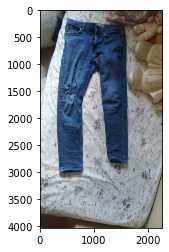

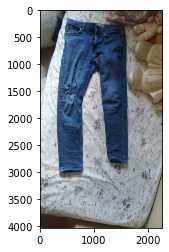

In [17]:
pant_img = pant_img_original[:,:,::-1]
plt.imshow(pant_img)

In [18]:
pant_img_gray = cv2.cvtColor(pant_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(pant_img_gray, (7, 7), 0)
(thresh, blackAndWhiteImage) = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

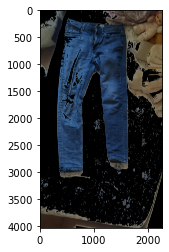

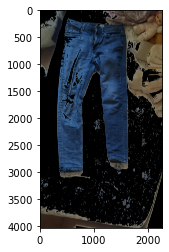

In [19]:
invertedMask = cv2.bitwise_not(blackAndWhiteImage)
newImage = cv2.bitwise_or(pant_img, pant_img, mask = invertedMask)
plt.imshow(newImage)

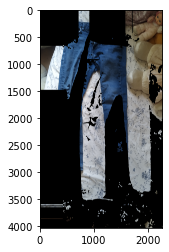

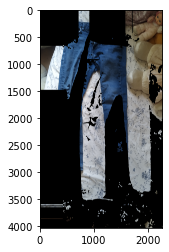

In [20]:
kernelClose = np.ones((10,10),np.uint8)
redoneInverted = invertedMask
for x in range(15):
    redoneInverted = cv2.morphologyEx(redoneInverted, cv2.MORPH_CLOSE, kernelClose)
for x in range(400):
    redoneInverted = cv2.morphologyEx(redoneInverted, cv2.MORPH_OPEN, kernelClose)
newImage = cv2.bitwise_or(pant_img, pant_img, mask = redoneInverted)
plt.imshow(newImage)

We can see here that, by using traditional steps, we cannot get a good enough definition of the pants, and therefore, it is of no use. What we will do instead, is to create a CNN to detect those pants, and later apply wathever it is needed to form it and develop it as needed

# Loading existing model

Once we have the existing model, we can load it up and make the necessay predictions.
Look at: PantsModel_Training.ipynb

In [21]:
model = models.load_model('saved_model/pantsModel_balanced')

In [22]:
def predict(img_name):
    img=image.load_img(img_name,target_size=(224,224))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    prediction=model.predict(img.reshape(1, 224, 224, 3))
    output=np.argmax(prediction)
    print(output)
    return output

In [23]:
pictureRoute = r'GoodUp.jpg'

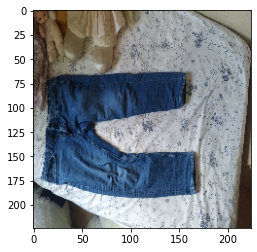

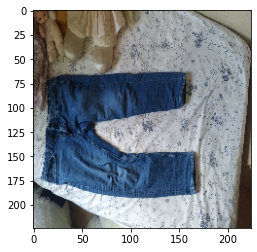

0
Long Pants
0
Long Pants


In [24]:
result = predict(pictureRoute) #Test prediction
if result == 0:
    print("Long Pants")
elif result == 1:
    print("Short Pants")
elif result == 2:
    print("Top")

In [25]:
if result == 0:
    print("It is a corrent pant form")

It is a corrent pant form
It is a corrent pant form


Interestingly enough, we get a good output, labeled as long-pants

# Extracting pants from the picture

We are going to apply a heatmap mask from the model and try to extract the pants form

In [26]:
def maskExtraction(orig, model, intensity=0.5, res=224):
    img = image.load_img(orig, target_size=(res, res))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv5_block3_out')
        iterate = models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))
    img = cv2.imread(orig)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    return heatmap

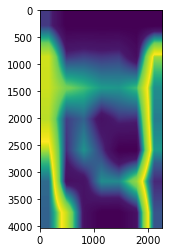

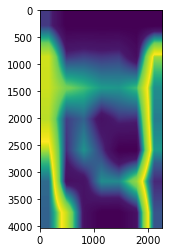

In [28]:
heatmap = maskExtraction(pictureRoute, model)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
plt.imshow(heatmap)
#(thresh, blackAndWhiteImage) = cv2.threshold(heatmap, 0, 255, cv2.THRESH_OTSU)
#invertedMask = cv2.bitwise_not(blackAndWhiteImage)
#plt.imshow(invertedMask)
#newImage = cv2.bitwise_or(pant_img, pant_img, mask = invertedMask)


# Rotation and scaling

For now we are going to work on a new dataset to progress on the project, therefore let's load it

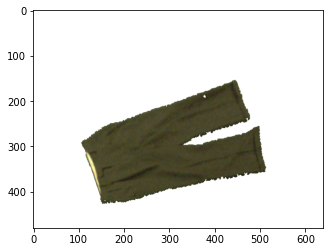

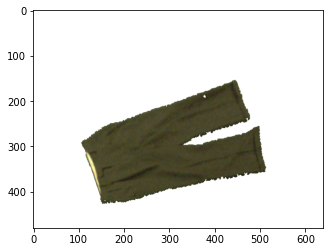

In [42]:
img_original = cv2.imread(r'SimplePants\wide_stereo_optical_frame_birdseye_2010-09-07-20-46-50_thresh.png', cv2.IMREAD_UNCHANGED)
img = img_original[:,:,::-1]
plt.imshow(img)

We would like to rotate to set the correct orientation, as well as to scale the image as needed

In [43]:
TargetHeight = 400


# Finding shape and normalizing form

The idea is to set it as normal as possible to be able to detect diferent forms or things